In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Defining Functions

In [2]:
def rmsle(y, pred):
    log_y    = np.log1p(y)
    log_pred = np.log1p(pred)
    rmsle = np.sqrt(np.mean((log_y-log_pred)**2.))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_error(y, pred, show=True):
    rmsle_val = rmsle(y, pred)
    rmse_val  = rmse(y, pred)
    mae_val   = mean_absolute_error(y, pred)
    if show:
        print('RMSLE: {0:.4f}'.format(rmsle_val), end=" | ")
        print('RMSE : {0:.4f}'.format(rmse_val), end=" | ")
        print('MAE  : {0:.4f}'.format(mae_val))
    return rmsle_val, rmse_val, mae_val

# Reading Train and Test Sets

In [3]:
train = pd.read_csv('./bike_train.csv', parse_dates=["datetime"])
print(train.shape)

(10886, 12)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [5]:
test = pd.read_csv('./bike_test.csv', parse_dates=["datetime"])
print(test.shape)

(6493, 9)


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


# Feature Engineering

## 1) datetime > year, month, day, hour, dayofweek

In [7]:
def datetime_separator(df):
    df["year"]  = df['datetime'].dt.year
    df["month"] = df['datetime'].dt.month
    df["day"]   = df['datetime'].dt.day
    df["hour"]  = df['datetime'].dt.hour
    df["dayofweek"] = df['datetime'].dt.dayofweek
    return df

In [8]:
train = datetime_separator(train)
test  = datetime_separator(test)

## 2) Categorical Features

In [9]:
categorical_features = ["year", "month", "day", "hour", "holiday", 
                        "workingday", "dayofweek", "weather", "season"]
for feature in categorical_features:
    train[feature] = train[feature].astype('category')

In [10]:
categorical_features = ["year", "month", "day", "hour", "holiday", 
                        "workingday", "dayofweek", "weather", "season"]
for feature in categorical_features:
    test[feature] = test[feature].astype('category')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  category      
 13  month       10886 non-null  category      
 14  day         10886 non-null  category      
 15  hour        10886 non-null  category      
 16  dayofweek   10886 non-

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   category      
 2   holiday     6493 non-null   category      
 3   workingday  6493 non-null   category      
 4   weather     6493 non-null   category      
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
 9   year        6493 non-null   category      
 10  month       6493 non-null   category      
 11  day         6493 non-null   category      
 12  hour        6493 non-null   category      
 13  dayofweek   6493 non-null   category      
dtypes: category(9), datetime64[ns](1), float64(3), int64(1)
memory usage: 313.5 KB


## 3) Outlier Analysis

<AxesSubplot:xlabel='weather', ylabel='count'>

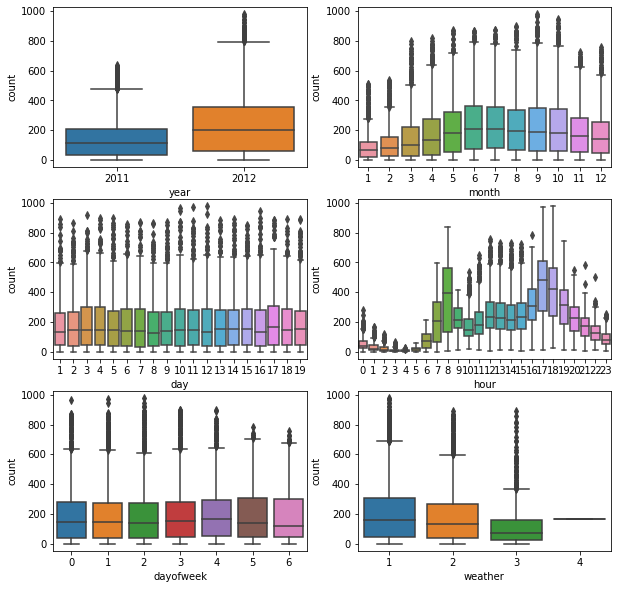

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
sns.boxplot(data=train, x="year", y="count",  ax=ax[0,0])
sns.boxplot(data=train, x="month", y="count", ax=ax[0,1])
sns.boxplot(data=train, x="day", y="count",   ax=ax[1,0])
sns.boxplot(data=train, x="hour", y="count",  ax=ax[1,1])
sns.boxplot(data=train, x="dayofweek", y="count",  ax=ax[2,0])
sns.boxplot(data=train, x="weather", y="count",  ax=ax[2,1])

<AxesSubplot:xlabel='count', ylabel='Count'>

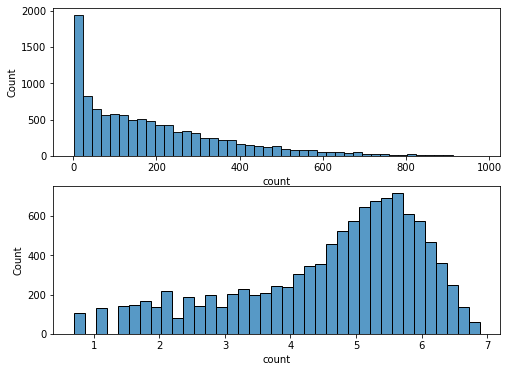

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))
sns.histplot(train['count'], ax=ax[0])
sns.histplot(np.log1p(train['count']), ax=ax[1])

- Count data is very left-sided skewed. Do we regard this skewness as outliers?

In [15]:
train_wo_outliers = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 

<AxesSubplot:xlabel='weather', ylabel='count'>

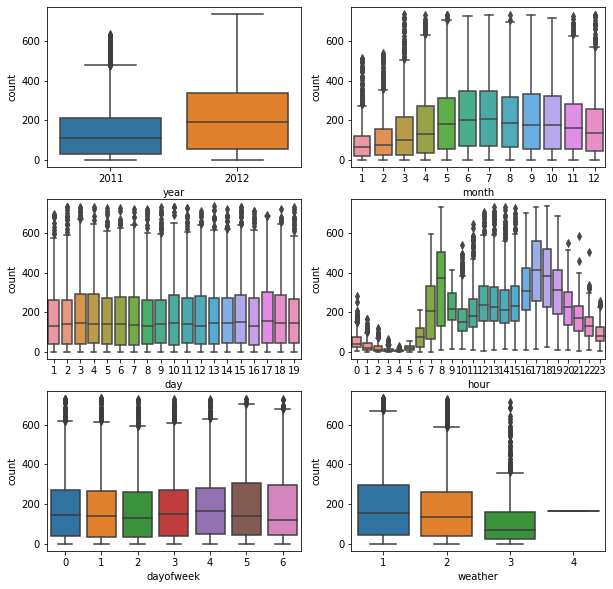

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
sns.boxplot(data=train_wo_outliers, x="year",      y="count",   ax=ax[0,0])
sns.boxplot(data=train_wo_outliers, x="month",     y="count",   ax=ax[0,1])
sns.boxplot(data=train_wo_outliers, x="day",       y="count",   ax=ax[1,0])
sns.boxplot(data=train_wo_outliers, x="hour",      y="count",   ax=ax[1,1])
sns.boxplot(data=train_wo_outliers, x="dayofweek", y="count",   ax=ax[2,0])
sns.boxplot(data=train_wo_outliers, x="weather",   y="count",   ax=ax[2,1])

## 4) correlation analysis

<AxesSubplot:>

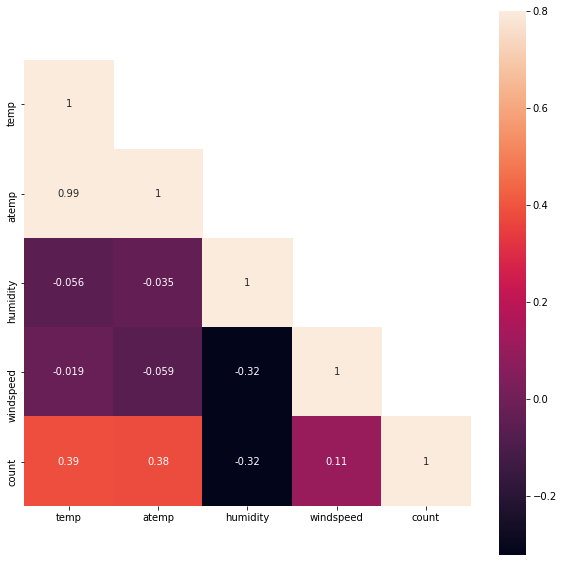

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
corr = train_wo_outliers[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corr, mask=mask,vmax=.8, square=True, annot=True)

- Correlation between 'temp' and 'atemp' is 0.99, which is very highly correlated. 
- Correlation between 'count' and 'windspeed' is the lowest among continuous features. 

## 5) 0's values in 'windspeed' : dropout

In [18]:
print(train.windspeed.count())
print(train_wo_outliers.windspeed.count())
print(train_wo_outliers[train_wo_outliers['windspeed']==0].windspeed.count())

10886
10739
1297


## 6) Conclusion

- Dropping the following features: datetime, day, casual, registered
- Eliminating outliers: We might use different criteria on outliers.
- Dropping 'atemp', since it is highly correlated with 'temp'
- Dropping 0's windspeed data
- skewed count data -> log transformation
- One-Hot Encoding for categorical features

### Dropping some features

In [19]:
train_wo_outliers = train_wo_outliers.drop(["datetime", "casual", "registered", "day", "atemp"], axis=1)

### Dropping 0's windspeed data

In [20]:
train_df = train_wo_outliers[train_wo_outliers['windspeed']!=0]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9442 entries, 5 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      9442 non-null   category
 1   holiday     9442 non-null   category
 2   workingday  9442 non-null   category
 3   weather     9442 non-null   category
 4   temp        9442 non-null   float64 
 5   humidity    9442 non-null   int64   
 6   windspeed   9442 non-null   float64 
 7   count       9442 non-null   int64   
 8   year        9442 non-null   category
 9   month       9442 non-null   category
 10  hour        9442 non-null   category
 11  dayofweek   9442 non-null   category
dtypes: category(8), float64(2), int64(2)
memory usage: 444.8 KB


### One-Hot Encoding

In [21]:
y_target = train_df['count']
X_features = train_df.drop(['count'], axis=1, inplace=False)

categorical_features = ["year", "month", "hour", "holiday", 
                        "workingday", "weather", "season", "dayofweek"]

X_features_ohe = pd.get_dummies(X_features, columns=categorical_features)

In [22]:
X_features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9442 entries, 5 to 10885
Data columns (total 60 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          9442 non-null   float64
 1   humidity      9442 non-null   int64  
 2   windspeed     9442 non-null   float64
 3   year_2011     9442 non-null   uint8  
 4   year_2012     9442 non-null   uint8  
 5   month_1       9442 non-null   uint8  
 6   month_2       9442 non-null   uint8  
 7   month_3       9442 non-null   uint8  
 8   month_4       9442 non-null   uint8  
 9   month_5       9442 non-null   uint8  
 10  month_6       9442 non-null   uint8  
 11  month_7       9442 non-null   uint8  
 12  month_8       9442 non-null   uint8  
 13  month_9       9442 non-null   uint8  
 14  month_10      9442 non-null   uint8  
 15  month_11      9442 non-null   uint8  
 16  month_12      9442 non-null   uint8  
 17  hour_0        9442 non-null   uint8  
 18  hour_1        9442 non-null

### Log transformation

In [23]:
y_target_log = np.log1p(y_target)

### Data Shuffling

In [24]:
from sklearn.utils import shuffle
X_features_ohe, y_target_log = shuffle(X_features_ohe, y_target_log, random_state = 0)

------------

# Random Forest Regression

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=156, n_jobs=-1)
scores = cross_val_score(rf_reg, X_features_ohe, y_target_log, 
                         scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rmsle_list = np.sqrt(-scores)
print(np.round(rmsle_list,4))
print(np.round(np.mean(rmsle_list),4))

[0.3408 0.3387 0.3198 0.338  0.3118 0.335  0.3013 0.323  0.3507 0.3325]
0.3291


In [30]:
rf_reg.fit(X_features_ohe, y_target_log)
pred = rf_reg.predict(X_features_ohe)
score = rmse(y_target_log, pred)
print(np.round(score,4))

0.1219


In [31]:
n_estimators_list = [50, 100, 200, 300, 500, 1000]

for n_estimators in n_estimators_list:
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, 
                                   random_state=156, n_jobs=-1)
    scores = cross_val_score(rf_reg, X_features_ohe, y_target_log, 
                             scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    rmsle_list = np.sqrt(-scores)
    print("n_estimators: {0}, {1:.4f}".format(n_estimators, 
                                              np.round(np.mean(rmsle_list),4)))    

n_estimators: 50, 0.3388
n_estimators: 100, 0.3370
n_estimators: 200, 0.3353
n_estimators: 300, 0.3347
n_estimators: 500, 0.3342
n_estimators: 1000, 0.3342


In [34]:
max_depth_list = [50, 100, 200, 300, 500]

for max_depth in max_depth_list:
    rf_reg = RandomForestRegressor(n_estimators=300, max_depth=max_depth,
                                   random_state=156, n_jobs=-1)
    scores = cross_val_score(rf_reg, X_features_ohe, y_target_log, 
                             scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    rmsle_list = np.sqrt(-scores)
    print("max_depth: {0}, {1:.4f}".format(max_depth, 
                                           np.round(np.mean(rmsle_list),4)))    

max_depth: 50, 0.3347
max_depth: 100, 0.3347
max_depth: 200, 0.3347
max_depth: 300, 0.3347
max_depth: 500, 0.3347


# Gradient Boosting Regression

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


gbm_reg = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)
%time scores = cross_val_score(gbm_reg, X_features_ohe, y_target_log, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rmsle_list = np.sqrt(-scores)
print(np.round(rmsle_list,4))
print(np.round(np.mean(rmsle_list),4))

CPU times: user 55.8 ms, sys: 4.28 ms, total: 60.1 ms
Wall time: 48.5 s
[0.2998 0.3137 0.3106 0.2984 0.2848 0.304  0.2793 0.2972 0.2991 0.2981]
0.2985


In [42]:
n_estimators_list = [50, 100, 200, 300, 500, 1000, 2000, 3000, 4000]

for n_estimators in n_estimators_list:
    gbm_reg = GradientBoostingRegressor(n_estimators=n_estimators)
    scores = cross_val_score(gbm_reg, X_features_ohe, y_target_log, 
                             scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    rmsle_list = np.sqrt(-scores)
    print("n_estimators: {0}, {1:.4f}".format(n_estimators, 
                                              np.round(np.mean(rmsle_list),4))) 

n_estimators: 50, 0.6103
n_estimators: 100, 0.4744
n_estimators: 200, 0.3965
n_estimators: 300, 0.3533
n_estimators: 500, 0.3203
n_estimators: 1000, 0.3035
n_estimators: 2000, 0.2985
n_estimators: 3000, 0.2994
n_estimators: 4000, 0.3014


In [47]:
alpha_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]

for alpha in alpha_list:
    gbm_reg = GradientBoostingRegressor(n_estimators=2000, alpha=alpha)
    scores = cross_val_score(gbm_reg, X_features_ohe, y_target_log, 
                             scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    rmsle_list = np.sqrt(-scores)
    print("alpha: {0:.4f}, {1:.4f}".format(alpha, 
                                              np.round(np.mean(rmsle_list),4))) 

alpha: 0.0010, 0.2985
alpha: 0.0030, 0.2984
alpha: 0.0100, 0.2983
alpha: 0.0300, 0.2985
alpha: 0.1000, 0.2985
alpha: 0.3000, 0.2983


In [48]:
gbm_reg = GradientBoostingRegressor(n_estimators=2000, alpha=0.01)
gbm_reg.fit(X_features_ohe, y_target_log)
pred = gbm_reg.predict(X_features_ohe)
score = rmse(y_target_log, pred)
print(np.round(score,4))

0.2151


# XGBoost Regression

In [49]:
from xgboost import XGBRegressor

In [50]:
help(XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |  
 |      max_depth : int
 |          Maximum tree depth for base learners.
 |      learning_rate : float
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : int
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |      objective : string or callable
 |          Specify the learning task and the corresponding learning objective or
 |          a custom objective function to be used (see note below).
 |      booster: string
 |          Specify which booster to use: gbtree, gblinear or dart.
 |      tree_method: string
 |          Specify which tree method to use.  Default to auto.  If this param

In [62]:
xgb_reg = XGBRegressor(n_estimators=500)
%time scores = cross_val_score(xgb_reg, X_features_ohe, y_target_log, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rmsle_list = np.sqrt(-scores)
print(np.round(rmsle_list,4))
print(np.round(np.mean(rmsle_list),4))

CPU times: user 46.5 ms, sys: 20.3 ms, total: 66.8 ms
Wall time: 2min 15s
[0.3284 0.3289 0.3184 0.3046 0.3224]
0.3205


In [54]:
xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_features_ohe, y_target_log)
pred = xgb_reg.predict(X_features_ohe)
score = rmse(y_target_log, pred)
print(np.round(score,4))

0.0583


# Light GBM Regression

In [63]:
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(n_estimators=500)
%time scores = cross_val_score(lgbm_reg, X_features_ohe, y_target_log, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rmsle_list = np.sqrt(-scores)
print(np.round(rmsle_list,4))
print(np.round(np.mean(rmsle_list),4))

CPU times: user 54.3 ms, sys: 129 ms, total: 184 ms
Wall time: 1.31 s
[0.3046 0.2976 0.2896 0.2851 0.2964]
0.2947


In [57]:
lgbm_reg = LGBMRegressor(n_estimators=500)
lgbm_reg.fit(X_features_ohe, y_target_log)
pred = lgbm_reg.predict(X_features_ohe)
score = rmse(y_target_log, pred)
print(np.round(score,4))

0.1863


In [68]:
from lightgbm import LGBMModel

In [69]:
help(LGBMModel)

Help on class LGBMModel in module lightgbm.sklearn:

class LGBMModel(sklearn.base.BaseEstimator)
 |  Implementation of the scikit-learn API for LightGBM.
 |  
 |  Method resolution order:
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |      Construct a gradient boosting model.
 |      
 |      Parameters
 |      ----------
 |      boosting_type : string, optional (default='gbdt')
 |          'gbdt', traditional Gradient Boosting Decision Tree.
 |          'dart', Dropouts meet Multiple Additive Regression Trees.
 |          'gos

In [64]:
help(LGBMRegressor)

Help on class LGBMRegressor in module lightgbm.sklearn:

class LGBMRegressor(LGBMModel, sklearn.base.RegressorMixin)
 |  LightGBM regressor.
 |  
 |  Method resolution order:
 |      LGBMRegressor
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.RegressorMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbacks=None, init_model=None)
 |      Build a gradient boosting model from the training set (X, y).
 |      
 |      Parameters
 |      ----------
 |      X : array-like or sparse matrix of shape = [n_samples, n_features]
 |          Input feature matrix.
 |      y : array-like of shape = [n_samples]
 |          The target values (class labels in classification, real numbers in regression).
 |      samp

## Grid Search on Hyper Parameters

In [70]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100, 300, 500, 800, 1000], 
          'learning_rate':[0.01, 0.03, 0.1, 0.3],
          'max_depth':[10, 30, 100, 300],
          'reg_lambda':[0.01, 0.03, 0.1, 0.3, 1, 3, 10], 
          'reg_alpha':[0.01, 0.03, 0.1, 0.3, 1, 3, 10]}

lgbm_reg = LGBMRegressor()
grid_model = GridSearchCV(estimator=lgbm_reg, param_grid=params, scoring='neg_mean_squared_error',
                                cv=5, return_train_score=True, n_jobs=-1)
%time grid_model.fit(X_features_ohe, y_target_log)
print(np.sqrt(-1*grid_model.best_score_))
print(grid_model.best_params_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 1min 57s, sys: 6.3 s, total: 2min 4s
Wall time: 30min 28s
0.2934205443290783
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'reg_alpha': 0.01, 'reg_lambda': 0.03}


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[500, 800, 1000], 
          'learning_rate':[0.01, 0.03, 0.1, 0.3],
          'max_depth':[0, 30, 100, 300],
          'reg_lambda':[0.01, 0.03, 0.1, 0.3, 1], 
          'reg_alpha':[0.01, 0.03, 0.1, 0.3, 1],
          'num_leaves':[31, 50, 90, 120]}

lgbm_reg = LGBMRegressor()
grid_model = GridSearchCV(estimator=lgbm_reg, param_grid=params, scoring='neg_mean_squared_error',
                                cv=5, return_train_score=True, n_jobs=-1)
%time grid_model.fit(X_features_ohe, y_target_log)
print(np.sqrt(-1*grid_model.best_score_))
print(grid_model.best_params_)

In [77]:
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.03, max_depth=0)
%time scores = cross_val_score(lgbm_reg, X_features_ohe, y_target_log, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rmsle_list = np.sqrt(-scores)
print(np.round(rmsle_list,4))
print(np.round(np.mean(rmsle_list),4))

CPU times: user 29.8 ms, sys: 46 µs, total: 29.9 ms
Wall time: 1.39 s
[0.3037 0.2994 0.2892 0.2809 0.2998]
0.2946


In [67]:
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.03, max_depth=0)
lgbm_reg.fit(X_features_ohe, y_target_log)
pred = lgbm_reg.predict(X_features_ohe)
score = rmse(y_target_log, pred)
print(np.round(score,4))

0.2173


In [32]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.1, 
                         max_depth=0, reg_alpha=0.01, reg_lambda=0.03)
%time scores = cross_val_score(lgbm_reg, X_features_ohe, y_target_log, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rmsle_list = np.sqrt(-scores)
print(np.round(rmsle_list,4))
print(np.round(np.mean(rmsle_list),4))

CPU times: user 25.2 ms, sys: 4.06 ms, total: 29.3 ms
Wall time: 884 ms
[0.3036 0.3022 0.291  0.2859 0.3002]
0.2966


In [33]:
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.1, 
                         max_depth=0, reg_alpha=0.01, reg_lambda=0.03)
lgbm_reg.fit(X_features_ohe, y_target_log)
pred = lgbm_reg.predict(X_features_ohe)
score = rmse(y_target_log, pred)
print(np.round(score,4))

0.145


# Test set manipulations

In [35]:
test_df = test.drop(["datetime", "day", "atemp"], axis=1)

In [36]:
categorical_features = ["year", "month", "hour", "holiday", 
                        "workingday", "weather", "season", "dayofweek"]

test_df_ohe = pd.get_dummies(test_df, columns=categorical_features)

# Submit

In [37]:
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.1, 
                         max_depth=0, reg_alpha=0.01, reg_lambda=0.03)
lgbm_reg.fit(X_features_ohe, y_target_log)
predictions = lgbm_reg.predict(test_df_ohe)
predictions = np.expm1(predictions)

In [38]:
submission = pd.read_csv("./sampleSubmission.csv")
submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.321557
1,2011-01-20 01:00:00,4.046588
2,2011-01-20 02:00:00,3.218074
3,2011-01-20 03:00:00,2.161076
4,2011-01-20 04:00:00,1.411693


In [39]:
submission.to_csv("./Score_submission_02142021_LGBM.csv", index=False)